In [1]:
%load_ext autoreload
%autoreload 2

from preproccessing import loadStooqData
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pyesg
import seaborn as sns
import matplotlib.pyplot as plt
from evaluation import show_scenarios_evaluation

In [2]:
data = loadStooqData('cpiypl.m','1973-12-31','y')

In [334]:
data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 51 entries, 1973-12-31 to 2023-12-31
Series name: Zamkniecie
Non-Null Count  Dtype  
--------------  -----  
51 non-null     float64
dtypes: float64(1)
memory usage: 816.0 bytes


In [13]:
def ornstein_uhlenbeck_params(series,period):
    lagged = series.shift(1).dropna()
    series = series.iloc[1:]
    lagged = sm.add_constant(lagged,prepend=False)
    model = sm.OLS(series['Zamkniecie'],lagged[['Zamkniecie','const']])
    res = model.fit()
    b = res.params['Zamkniecie']
    a = res.params['const']
    k = (1 -b)/period
    u = a/(1-b)
    sig = np.sqrt(res.scale)
    
    return (u,sig,k)


,Zamkniecie
count,21.000000
mean,0.031957
std,0.035149
min,-0.010050
2%,-0.008035
5%,-0.005013
10%,0.006976
25%,0.010940
50%,0.023717
75%,0.039221


<AxesSubplot:xlabel='Data', ylabel='Zamkniecie'>

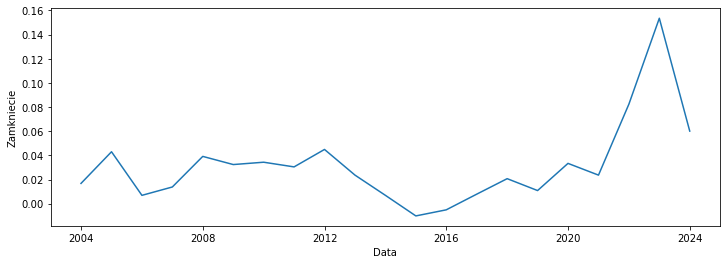

In [28]:
cpi = data['2003-01-01':'2023-12-31'] / 100
cpi = np.log(cpi+1)
cpi = cpi.reset_index()
cpi.set_index(cpi['Data'])
display(cpi.describe(percentiles=[0.02,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.98]))
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=cpi,x='Data',y='Zamkniecie', ax=ax)

<AxesSubplot:xlabel='Zamkniecie', ylabel='Count'>

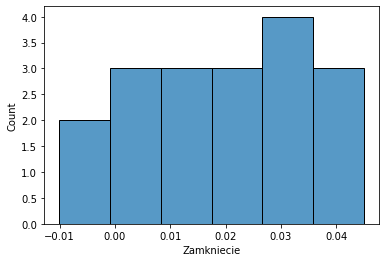

In [11]:
sns.histplot(data=cpi['Zamkniecie'])

In [29]:
u,sig,k = ornstein_uhlenbeck_params(cpi,1)
print(u)
print(sig)
print(k)

0.03533804215688417
0.03099820223980683
0.4518448082273404


In [359]:
model = tsa.MarkovAutoregression(cpi['Zamkniecie'],4,order=1,switching_variance=True,switching_ar=True)
res = model.fit() 
res.summary()

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1291: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:               Zamkniecie   No. Observations:                   40
Model:             MarkovAutoregression   Log Likelihood                 152.506
Date:                  Mon, 12 Feb 2024   AIC                           -257.012
Time:                          15:43:36   BIC                           -216.479
Sample:                               0   HQIC                          -242.356
                                   - 40                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009        nan        nan        nan         nan         nan
sigma2      1.572e-25        nan        nan        nan         nan         nan
ar.L1      -3.167e-05   7.09e-11  -4.47e+05      0.000   -3.17e-05   -3.17e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0151        nan        nan        nan         nan         nan
sigma2      2.123e-07   1.91e-12   1.11e+05      0.000    2.12e-07    2.12e-07
ar.L1          0.2865   2.35e-11   1.22e+10      0.000       0.286       0.286
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0262        nan        nan        nan         nan         nan
sigma2      9.818e-06   4.83e-06      2.035      0.042     3.6e-07    1.93e-05
ar.L1          0.2784   1.02e-11   2.72e+10      0.000       0.278       0.278
                             Regime 3 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366   7.51e-09   4.88e+06      0.000       0.037       0.037
sigma2         0.0002   2.67e-08   8081.445      0.000       0.000       0.000
ar.L1          0.5521   1.18e-11   4.67e+10      0.000       0.552       0.552
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]      1.79e-13        nan        nan        nan         nan         nan
p[1->0]     1.222e-07        nan        nan        nan         nan         nan
p[2->0]     8.284e-05        nan        nan        nan         nan         nan
p[3->0]        0.0453        nan        nan        nan         nan         nan
p[0->1]        0.0023        nan        nan        nan         nan         nan
p[1->1]        0.2347        nan        nan        nan         nan         nan
p[2->1]        0.3256        nan        nan        nan         nan         nan
p[3->1]        0.0370        nan        nan        nan         nan         nan
p[0->2]        0.9977        nan        nan        nan         

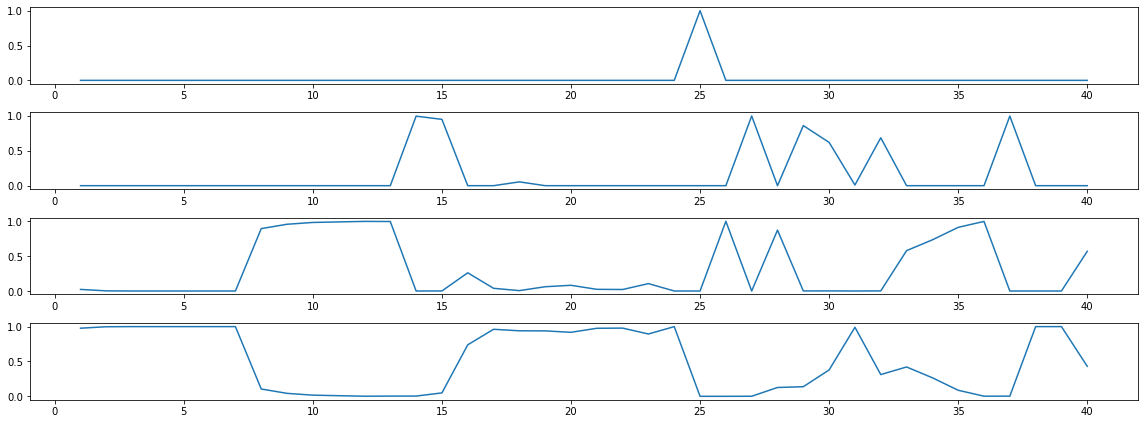

In [343]:
fig, axes = plt.subplots(4, figsize=(16, 6))
ax = axes[0]
ax.plot(res.filtered_marginal_probabilities[0])

ax = axes[1]
ax.plot(res.smoothed_marginal_probabilities[1])

ax = axes[2]
ax.plot(res.smoothed_marginal_probabilities[2])

ax = axes[3]
ax.plot(res.smoothed_marginal_probabilities[3]) 

fig.tight_layout()

In [106]:
res.params

p[0->0]      0.709447
p[1->0]      0.352884
p[2->0]      0.000000
p[0->1]      0.290553
p[1->1]      0.400066
p[2->1]      0.499339
const[0]     0.004289
const[1]     0.033926
const[2]     0.075830
sigma2[0]    0.000083
sigma2[1]    0.000008
sigma2[2]    0.002397
ar.L1[0]     0.331792
ar.L1[1]     0.342896
ar.L1[2]     0.130380
dtype: float64

In [33]:
#moje param mu - 2,5%, sig, 1,5%, k- 0.k
param_mu = 0.03 #u
param_sig = 0.03 #sig
param_k = 0.45 #k
simulator = pyesg.OrnsteinUhlenbeckProcess(mu=param_mu,sigma=param_sig,theta=param_k)

In [34]:
length = 30
h= 1
scenarios = simulator.scenarios(0.06,h,1000,length)
scenarios = pd.DataFrame(scenarios)

#show_scenarios_evaluation(scenarios,cpi['Zamkniecie'])

Sample paths


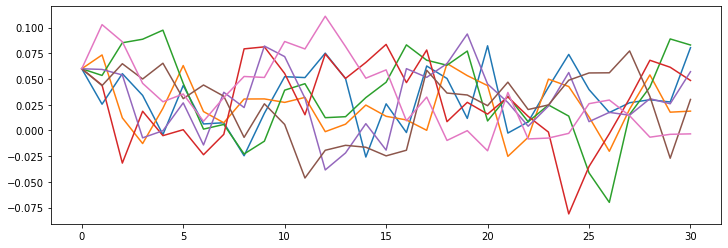

None
Fanchart


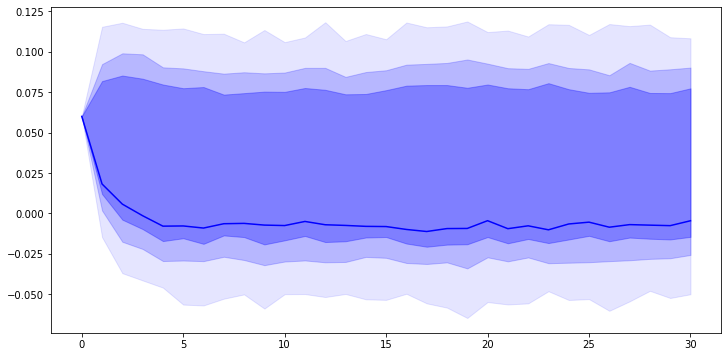

None
Percentaile summary


,1,3,5,10,20,30
1,-0.014710,-0.041450,-0.056414,-0.049970,-0.054840,-0.050001
5,0.001780,-0.022003,-0.029159,-0.029778,-0.027171,-0.025704
10,0.011990,-0.009709,-0.015364,-0.016673,-0.014642,-0.014509
15,0.018188,-0.001446,-0.007775,-0.007527,-0.004517,-0.004559
25,0.027517,0.011556,0.004851,0.007379,0.008583,0.009671
50,0.045957,0.035235,0.030810,0.030654,0.030713,0.031693
75,0.065594,0.059474,0.055780,0.053149,0.054815,0.052807
85,0.074431,0.073365,0.067151,0.066616,0.069313,0.067247
90,0.081823,0.083297,0.077418,0.075159,0.079696,0.077327
95,0.092319,0.098382,0.089681,0.087109,0.092603,0.090170


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.032307,0.034116,-0.052486,-0.146907,10.880823,-0.072973
std,0.011290,0.005656,0.417070,0.720908,4.782353,0.059855
min,-0.002950,0.020043,-1.352848,-1.467913,-1.916464,-0.363377
25%,0.025216,0.030403,-0.326028,-0.654887,7.618574,-0.100778
50%,0.032409,0.033771,-0.036584,-0.282383,10.480753,-0.057954
75%,0.039835,0.037481,0.208468,0.200598,13.649542,-0.029206
max,0.068662,0.054761,1.459405,4.529208,29.597732,0.000000


In [37]:
from evaluation import describe_scenarios_vertically, fanchart, percentile_summary, sample_paths


print(sample_paths(scenarios))

print(fanchart(scenarios))
    
display(percentile_summary(scenarios, data_freq=1, years = np.array([1,3,5,10,20,30])))

cum_scenarios = scenarios.mean(axis=1)
display(describe_scenarios_vertically(scenarios.T,'y'))



In [ ]:
cum_ret = scenarios/100

In [167]:
#np.savetxt('inlfation_scenarios_23.09.23.csv',scenarios,comments='u=0.02,sig=0.014,k=0.64')

In [184]:
np.savetxt('edo_25.09.23_m.csv', np.round(edo,4),delimiter=', ', comments='testowa')

In [355]:
np.round(res.params,4)

p[0->0]      0.0153
p[1->0]      0.0185
p[2->0]      0.0257
p[3->0]      0.0676
p[0->1]      0.0748
p[1->1]      0.3702
p[2->1]      0.2875
p[3->1]      0.0833
p[0->2]      0.3943
p[1->2]      0.4162
p[2->2]      0.5533
p[3->2]      0.2942
const[0]     0.0059
const[1]     0.0153
const[2]     0.0279
const[3]     0.0492
sigma2[0]    0.0000
sigma2[1]    0.0000
sigma2[2]    0.0000
sigma2[3]    0.0001
ar.L1        0.5408
dtype: float64

In [363]:

def ou_params_transform(const, ar,dt):
    k=(1-ar)/dt
    u = const/(1-ar)
    return k,u

def ou_rs_params(params,k,dt):
    result = np.zeros((k,3))
    for r in range(k):
        p = ou_params_transform(params[f"const[{r}]"],params[f'ar.L1[{r}]'],dt)
        #p = ou_params_transform(params[f"const[{r}]"],params[f'ar.L1'],dt)
        result[r,0] = p[0]
        result[r,1] = p[1] 
        result[r,2] = np.sqrt(params[f'sigma2[{r}]']) *np.sqrt(dt)
    return result

print(np.round(ou_rs_params(res.params,4,1),3))

[[1.    0.001 0.   ]
 [0.714 0.021 0.   ]
 [0.722 0.036 0.003]
 [0.448 0.082 0.015]]


In [278]:
pl_cpi = loadStooqData('cpiypl.m','2003-12-31','y')
us_cpi = loadStooqData('cpiyus.m','1973-12-31','y')
pl_cpi.corr(us_cpi)

0.7966189478408742

#TODO
- single regime 2003-2021, albo 2020
- backfill
